<center><h1> Teoría de Portafolios </h1></center>
<center><h3> Universidad Externado de Colombia - Prof. Oscar Reyes </h3></center>
<br>
<br>
<center><h2> Notas de Clase </h2></center>
<center><h3> Miguel Angel Manrique Rodriguez </h3></center>
<center><h3> 2022-1S </h3></center>

    Al momento de querer realizar indexación de la ecuaciónes utilizar
        \newcommand{\owntag}[1]{\stepcounter{equation}\tag{\theequation. #1}}
    en el archivo .tex

Y luego agregar a la ecuación 
\begin{align}
\dot{x} & = \sigma(y-x)  \owntag{indice} \\
\end{align}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

sns.set_theme(font="Times New Roman",font_scale=1)

# Repaso estadística

# Portafolios de Inversión


## load_data
definimos una función que nos permita importar el precio ajustado de cualquier activo siempre y cuando conozcamos su symbolo de yahoo finance; además no permite graficar el retorno logarítimico de un período de cada activo

In [2]:
def load_data(symbols,start,end,plot):
    # Carga de datos

    data = pd.DataFrame({})
    for symbol in symbols:
        data_temp = yf.download(symbol, start=start, end=end,progress=False)
        data_temp = data_temp[['Adj Close']]
        data_temp = np.log(data_temp['Adj Close']) - np.log(data_temp['Adj Close'].shift(1))
        data_temp = data_temp.dropna()
        
        data = pd.concat([data,data_temp], axis=1)
        
    data.columns = symbols
    
    if plot==True:
        data.plot(figsize=(10,7))
        if len(symbols) > 3:
            plt.legend(loc='center right', bbox_to_anchor=(1,1),
                        fancybox=True, shadow=True, ncol=5)
        plt.title("logarithmic return", loc="left", fontdict = {'fontsize':18})
        plt.show()
    return data

In [3]:
symbols = ["TSLA","BAC","MA"]
data = load_data(symbols=symbols,start="2021-02-01", end="2022-02-01",plot=False)

### Matriz de Varianzas y Covarianzas, y coeficientes de correlación

In [4]:
vcov, corr = np.matrix(data.cov()) , np.matrix(data.corr())
print(f"""
Matriz de varianzas y covarianzas
---------------------------------
{vcov}
---------------------------------

Matriz de coeficientes de correlación

---------------------------------
{corr}
---------------------------------
""")


Matriz de varianzas y covarianzas
---------------------------------
[[1.28350870e-03 3.63019625e-05 1.10844435e-04]
 [3.63019625e-05 2.48961578e-04 9.08054596e-05]
 [1.10844435e-04 9.08054596e-05 3.36306974e-04]]
---------------------------------

Matriz de coeficientes de correlación

---------------------------------
[[1.         0.06421915 0.16871222]
 [0.06421915 1.         0.31381801]
 [0.16871222 0.31381801 1.        ]]
---------------------------------



## Riesgo (varianza) y retorno del portafolio
Ahora definimos una función que nos permita calcular la varianza del portafolio de acuerdo a un vector de ponderaciones que asignemos a cada activo en nuestro portafolio

### Retorno
El retorno esperado del portafolio se define como 

\begin{align}
E(r_{p}) &= E(\sum_{i=1}^{n}w_{i}r_{i}) = \sum_{i=1}^{n}w_{i}E(r_{i})  \owntag{3.1} \\
\end{align}

s.a $\sum_{i=1}^{n}w_{i}=1$, siendo $w_{i}$ la ponderación $w$ del activo $i$ en el portafolio y $E(r_{i})$ el retorno esperado del activo $i$

### Riesgo
La varianza del portafolio también se de conoce como el riesgo del portafolio, y en este caso estará determinada por 
 + La varianza individual de cada activo del portafolio
 + por el grado de dependencia medido por la covarianza o el coeficiente de correlación entre ellas 
 
En sentido estricto, el riesgo de de un portafolio se define como la variabailidad de los retornos del portafolio $r_{p}$, o en otras palabras, la dispersión de los retornos

\begin{align}
\sigma_{X}^{2} &= E[X-E(X)]^{2} \\
\sigma_{p}^{2} &= E[r_{p}-E(r_{p})]^{2} \owntag{3.2}
\end{align}

### Varianza del portafolio caso 2 activos

\begin{align}
\sigma_{p}^{2} &= E[r_{p}-E(r_{p})]^{2} \\ 
               &= E[w_{1}r_{1} + w_{2}r_{2} - (w_{1}E(r_{1}) + w_{2}E(r_{2})]^{2} \\
               &= E[w_{1}(r_{1}-E(r_{1})) + w_{2}(r_{2}-E(r_{2}))]^{2} \owntag{3.3}
\end{align}

Dado que $(a+b)^{2}=a^{2}+b^{2}+2ab$ y $E[x_{i}-E(x_{i})]^{2}=\sigma_{x}^{2}$, además, como $w_{i}$ es constante su valor esperado es $w_{i}$. 

\begin{align}
    \sigma_{p}^{2} = w_{1}^{2}\sigma_{1}^{2} + w_{2}^{2}\sigma_{2}^{2} + 2w_{1}w_{2}\sigma_{1,2}  \owntag{3.4}
\end{align}

In [3]:
def var_p(data,weights,vcov):
        
# Varianza del portafolio
    weights = np.array(weights)
    vp = weights @ vcov @ weights.T
    vp = vp[0,0]

# Retorno del portafolio 

    r_symbols = data.agg(np.average)
    rp = r_symbols @ weights
    
    return vp, rp 


In [6]:
Vp, Rp = var_p(data=data,weights=[0.05,0.8,0.15],vcov=vcov)
print(f"""
Varianza del portafolio
---------------------------------
{Vp}
---------------------------------

Retorno del portafolio

---------------------------------
{Rp}
---------------------------------
""")


Varianza del portafolio
---------------------------------
0.00019647122216668203
---------------------------------

Retorno del portafolio

---------------------------------
0.001565297823334792
---------------------------------



# Portafolios de Markowitz

## Defenición

Un portafolio se dice eficiente en el sentido de markowitz si:
 + Tiene el retorno esperado más alto para un nivel dado de riesgo
 + Tiene el riesgo esperado más bajo dado un nivel de retorno esperado


## Análisis Retorno / Riesgo
Dado los pesos [0.03,0.3,0.4] obtenemos el siguiente retorno/riesgo del portafolio

In [7]:
Vp, Rp = var_p(data=data,weights=[0.3,0.3,0.4],vcov=vcov)
print(f"""
Riesgo del portafolio
---------------------------------
{(Vp)**(1/2)}
---------------------------------

Retorno del portafolio

---------------------------------
{Rp}
---------------------------------
Retorno / Riesgo del portafolio
---------------------------------
{Rp/((Vp)**(1/2))}
---------------------------------
""")


Riesgo del portafolio
---------------------------------
0.01570546939854258
---------------------------------

Retorno del portafolio

---------------------------------
0.0009661044706111623
---------------------------------
Retorno / Riesgo del portafolio
---------------------------------
0.06151388704757935
---------------------------------



## Análisis Retorno / Riesgo N portafolios y frontera eficiente de Markowitz

El conjunto de todos los N portafolios eficientes desarrolla una curva en el espacio media-varianza llamada "frontera eficiente"

In [8]:
# 1 = w1 + w2 + w3
weights = np.random.dirichlet(np.ones(3),size=100)
RR = []
for weight in weights:
    Vp, Rp = var_p(data=data,weights=weight,vcov=vcov)
    RR.append(((Vp)**(1/2),Rp))

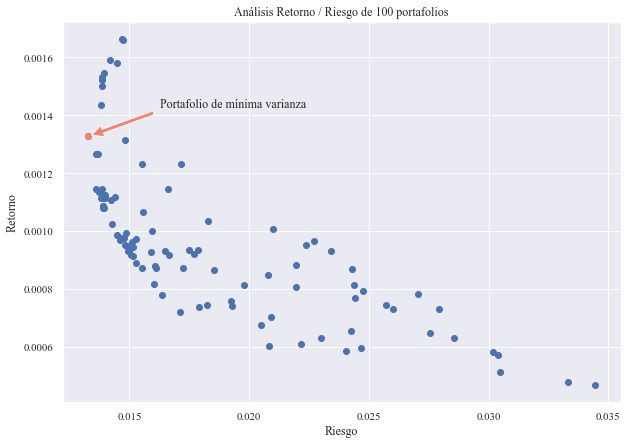

In [9]:
argmin = RR[np.argmin([i[0] for i in RR])]
fig = plt.figure(figsize=(10,7))
plt.scatter(x=[i[0] for i in RR], y = [i[1] for i in RR])
plt.scatter(x=argmin[0],y=argmin[1],color="salmon")
plt.annotate("Portafolio de mínima varianza",xy=(argmin[0],argmin[1]),xytext =(argmin[0]+0.0030, argmin[1]+0.0001), 
            arrowprops = dict(facecolor ='salmon',shrink = 0.05))
plt.title("Análisis Retorno / Riesgo de 100 portafolios")
plt.xlabel("Riesgo")
plt.ylabel("Retorno")
plt.show()

## Líneas de Isocuantas (Isomean) caso 2 activos

In [10]:
data = load_data(symbols=['TSLA','BAC'],start="2021-02-01", end="2022-02-01",plot=False)

Despejando $w_{2}$ de 3.1 obtenemos

\begin{align}
w_{2} &= \frac{E(r_{p})}{E(r_{2})} - \frac{E(r_{1})}{E(r_{2})}w_{1}  \owntag{4.1} \\
\end{align}

Donde $w_{1}$, $w_{2}$ y $E(r_{p})$ son tres variables enódgenas desconocidas y $E(r_{1})$ $E(r_{2})$ son dos variables exógenas conocidas Existen infinitas combinaciones de $w_{1}$ y $w_{2}$ que permiten alcanzar un mismo nivel de retorno esperado $E(r_{p})$. Por tanto, existen infinitas líneas como combinaciones de $w_{1}$ y $w_{2}$ para un mismo retorno de portafolio dado.

In [11]:
# Vamos a supones E(r_{p}) conocido
E_rp = np.arange(0,1,0.01)
E_r1 = np.arange(0,1,0.01)
E_r2 = np.arange(0,1,0.01)
w1 = np.arange(0,1,0.01)
w2 = (E_rp/E_r2) - (E_r1/E_r2)*w1

C:\Users\Laptop\AppData\Local\Temp\ipykernel_4648\3400882454.py:6: RuntimeWarning: invalid value encountered in true_divide
  w2 = (E_rp/E_r2) - (E_r1/E_r2)*w1


## Líneas de isovariance caso 2 activos

de 3.5 sabemos que $\sigma_{p}^{2} = w_{1}^{2}\sigma_{1}^{2} + w_{2}^{2}\sigma_{2}^{2} + 2w_{1}w_{2}\sigma_{1,2}$

In [12]:
sigma_p2 = w1*np.var(data['TSLA']) + w2*np.var(data['BAC']) + 2*w1*w2*data.cov().iloc[1,1]

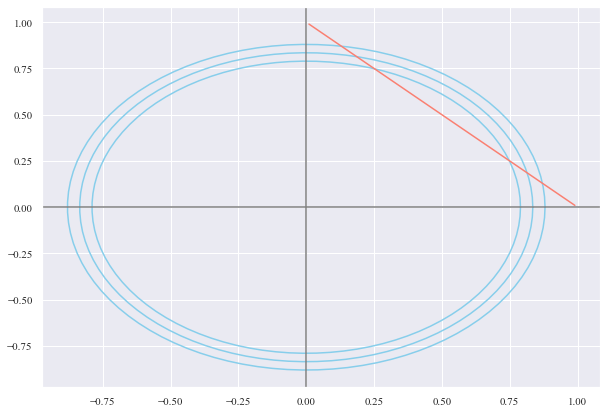

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi

fig = plt.figure(figsize=(10,7))

for sigmap in sigma_p2[1:4]:
    u=0     #x-position of the center
    v=0    #y-position of the center
    a=sigmap*3000    #radius on the x-axis
    b=sigmap*3000    #radius on the y-axis
    t = np.linspace(0, 2*pi, 100)
    plt.plot( u+a*np.cos(t) , v+b*np.sin(t),color="skyblue")

plt.plot(w1,w2, color="salmon")
plt.axhline(0,color="grey")
plt.axvline(0,color="grey")
plt.show()

# Diversificación de Markowitz

### Supuestos del modelo
 + No hay ventas en corto

## Cálculo de los pesos w

Para obtener el valor exacto de w1 y w2, que me permiten obtener el portafolio de mínimza varianza igualamos a 0 la derivada de la varianza del portafolio $\sigma_{p}^{2}$


\begin{align}
0=\frac{\partial{\sigma_{p}^{2}}}{\partial{w_{1}}} &= \frac{\partial{}}{\partial{w_{1}}} [w_{1}^{2}\sigma_{1}^{2}+(1-w_{1})^{2}\sigma_{2}^{2}+2w_{1}(1-w_{1})\sigma_{1,2}]  \owntag{5.1} \\
&= 2w_{1}\sigma_{1}^{2}-2(1-w_{1})^{2}\sigma_{2}^{2} + 2(1-2w_{1})\sigma_{1,2}\\
w_{1}&=\frac{\sigma_{2}^{2}-\sigma_{1,2}}{\sigma_{1}^{2}+\sigma_{2}^{2}-2\sigma_{1,2}}\\
w_{2}&= 1-w_{1}
\end{align}

## Diversificación

En el sentido de Markowtiz, cuanto menor sea la correlación de los activos de una cartera, menos reisgosa será esa cartera. Por el contrario, cuanto más se acerca a $+1$ la correlación de los activos, más riesgosa será la cartera; veamos.

 + $E(r_{1}) = 0.05$ , $E(r_{2}) = 0.15$
 + $\sigma_{1}=0.20$ , $\sigma_{2}=0.40$
 + $w_{1mvp} = 2/3$ , $w_{1mvp} = 1/3$

In [14]:
E_r1 = 0.05
E_r2 = 0.15
sigma_1 = 0.2
sigma_2 = 0.4
w1 = 2/3
w2 = 1/3

In [15]:
E_rp = w1*E_r1 + w2*E_r2
sigma_p1m = (w1**2)*(sigma_1)**2+(w2**2)*(sigma_2**2)
sigma_p2m = 2*((2/3)*(1/3))*(0.2)*(0.4)

In [16]:
rho = [1,0,-1]
for r in rho:
    print(f"Si el coeficiente de correlación es {r}, entonces la varianza del portafolio es","\n",
          round((sigma_p1m+(sigma_p2m*r))**(1/2),4),"\n")

Si el coeficiente de correlación es 1, entonces la varianza del portafolio es 
 0.2667 

Si el coeficiente de correlación es 0, entonces la varianza del portafolio es 
 0.1886 

Si el coeficiente de correlación es -1, entonces la varianza del portafolio es 
 0.0 



# Modelo media varianza MV

## Ejercicio pre-parcial

In [21]:
# symbols = ["TSLA","BAC","MA","KO","F"]
# # data = load_data(symbols=symbols, start='2011-02-01', end="2022-02-01",plot=False)
# data = pd.DataFrame({})
# for symbol in symbols:
#     data_temp = yf.download(symbol, start='2011-01-02', end='2022-01-02',progress=False)
#     data_temp = data_temp[['Adj Close']]
#     data = pd.concat([data,data_temp],axis=1)
# data.columns=symbols

# data = data.resample("M").last()

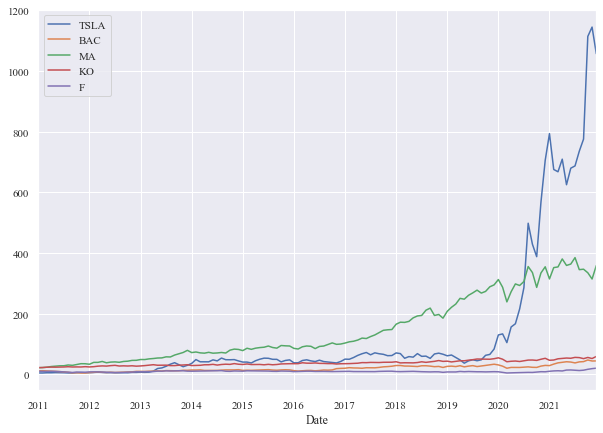

In [22]:
# data.plot(figsize=(10,7))
# plt.show()

In [62]:
# data = load_data(symbols=["TSLA","BAC","MA","KO","F"], start='2011-02-01',end='2022-02-01',plot=True)
# data = np.log(data) - np.log(data.shift(1))
# data = data.dropna()

In [6]:
data = pd.read_excel("retornos.xlsx")

In [8]:
# matriz de varianzas y covarianzas
vcov, corr = np.matrix(data.cov()) , np.matrix(data.corr())

# retorno esperado de los activos
E_ri = data.agg(np.mean)

# varianza y desviación estándar de los activos
var_i = np.diag(vcov)
sigma_i = np.sqrt(var_i)

### Construcción de los portafolios óptimos

In [9]:
n = len(E_ri)
ones = np.ones(n)
x = np.transpose(E_ri) @ np.linalg.inv(vcov) @ E_ri
y = np.transpose(E_ri) @ np.linalg.inv(vcov) @ ones
z = np.transpose(ones) @ np.linalg.inv(vcov) @ ones
d = x*z - y**2

In [10]:
g = (np.linalg.solve(vcov,ones) * np.array(x)-np.linalg.solve(vcov,E_ri)*np.array(y)) * 1/d
h = (np.linalg.solve(vcov,E_ri) * np.array(z)-np.linalg.solve(vcov,ones)*np.array(y)) * 1/d

In [11]:
Rp = np.linspace(start=np.min(E_ri), stop=np.max(E_ri),num=1000)
wpo = np.zeros((1000,n))
sigmapo = np.zeros(1000)
rpo = np.zeros(1000)

In [12]:
for i in range(1,1000):
    wi = g+h*Rp[i]
    sigmapo[i] = np.sqrt(wi@vcov@np.transpose(wi))
    rpo[i] = wi @ E_ri
    wpo[i] = wi

### Portafolio de mínima varianza


In [13]:
wpmv = np.linalg.solve(vcov,ones) * 1/z
rpmv = wpmv @ E_ri
sigmapmv = np.sqrt(wpmv@vcov@np.transpose(wpmv))

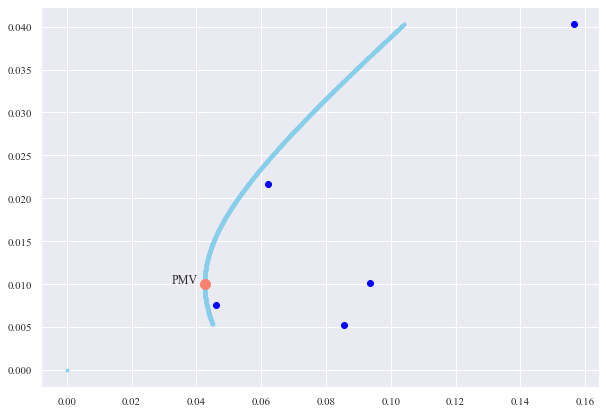

In [14]:
fig_pmv = plt.figure(figsize=(10,7))
plt.scatter(sigma_i,E_ri, color="blue")
plt.scatter(sigmapo,rpo,color="skyblue",s=8)
plt.scatter(sigmapmv[0,0],rpmv[0], color="salmon", s=100)
plt.annotate("PMV",xy=(sigmapmv[0,0],rpmv[0]),xytext =(sigmapmv[0,0]-0.010, rpmv[0]))
plt.show()

In [20]:
def PMV(data):
    # data = load_data(symbols=symbols, start='2011-02-01',end='2022-02-01',plot=True)
#     data = np.log(data) - np.log(data.shift(1))
#     data = data.dropna()
    # matriz de varianzas y covarianzas
    vcov, corr = np.matrix(data.cov()) , np.matrix(data.corr())

    # retorno esperado de los activos
    E_ri = data.agg(np.mean)

    # varianza y desviación estándar de los activos
    var_i = np.diag(vcov)
    sigma_i = np.sqrt(var_i)

    n = len(E_ri)
    ones = np.ones(n)
    x = np.transpose(E_ri) @ np.linalg.inv(vcov) @ E_ri
    y = np.transpose(E_ri) @ np.linalg.inv(vcov) @ ones
    z = np.transpose(ones) @ np.linalg.inv(vcov) @ ones
    d = x*z - y**2

    g = (np.linalg.solve(vcov,ones) * np.array(x)-np.linalg.solve(vcov,E_ri)*np.array(y)) * 1/d
    h = (np.linalg.solve(vcov,E_ri) * np.array(z)-np.linalg.solve(vcov,ones)*np.array(y)) * 1/d

    Rp = np.linspace(start=np.min(E_ri), stop=np.max(E_ri),num=1000)
    wpo = np.zeros((1000,n))
    sigmapo = np.zeros(1000)
    rpo = np.zeros(1000)

    wpmv = np.linalg.solve(vcov,ones) * 1/z
    rpmv = wpmv @ E_ri
    sigmapmv = np.sqrt(wpmv@vcov@np.transpose(wpmv))

    return wpmv, rpmv, sigmapmv

In [37]:
wpmv , rpmv , spmv = PMV(data=data)

In [38]:
print(f"""
Pesos del portafolio de mínima varianza
{wpmv}
----------------------------------------
Retorno del portafolio de mínima varianza
{rpmv}
----------------------------------------
Variaza del portafolio de mínima varianza
{spmv}
""")


Pesos del portafolio de mínima varianza
[[0.10502964 0.42774931 0.46722105]]
----------------------------------------
Retorno del portafolio de mínima varianza
[0.01887747]
----------------------------------------
Variaza del portafolio de mínima varianza
[[0.0400416]]



# Teoría de Sharpe
Maximización de la recta tangente

## Combinación de portafolios

\begin{align}
E(R_{q}) &= \alpha E(r_{p_{1}}) + (1-\alpha)E(r_{p_{2}}) \owntag{7.1}\\
\end{align}

Los pesos se determinan como

\begin{align}
w_{q} &= \alpha w_{p_{1}} + (a-\alpha)w_{p_{2}}\\
      &= \alpha[g+hE(r_{p_{1}})]+(1-\alpha)[g+hE(r_{p_{2}})]\\
      &= g + hE(r_{p_{q}})
\end{align}

## Frontera eficiente con el activo libre de riesgo
Dado un activo libre de riesgo su rendimiento está dado por una tasa libre de riesgo $r_{f}$ 

Partiendo del problema de minimización de la varianza 

\begin{align}
min & Var(r_{p_{q}})
\end{align}

In [21]:
# symbols = ["TSLA","BAC","MA","KO","F"]
# # data = load_data(symbols=symbols, start='2011-02-01', end="2022-02-01",plot=False)
# data = pd.DataFrame({})
# for symbol in symbols:
#     data_temp = yf.download(symbol, start='2011-01-02', end='2022-01-02',progress=False)
#     data_temp = data_temp[['Adj Close']]
#     data = pd.concat([data,data_temp],axis=1)
# data.columns=symbols

# data = data.resample("M").last()
data = pd.read_excel("retornos.xlsx")
wpmv , rpmv , spmv = PMV(data=data)

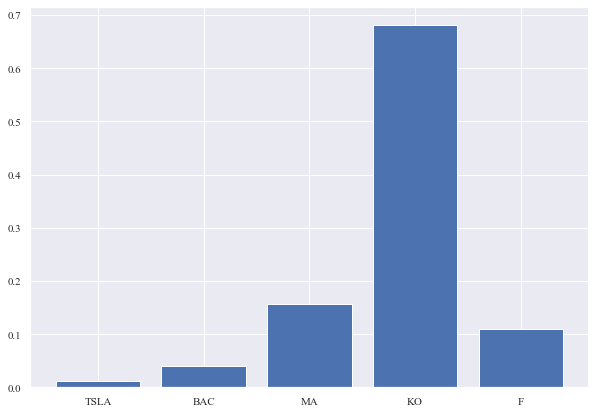

In [23]:
fig = plt.figure(figsize=(10,7))
plt.bar(["TSLA","BAC","MA","KO","F"],np.squeeze(np.asarray(wpmv)))
plt.show()

In [24]:
#Retornos esperados
E_ri = data.agg(np.average)

#Matriz de covarianzas
cov = np.matrix(data.cov())

#rf
rf = 0
er = E_ri - rf

#zi
zi = np.linalg.solve(cov,er)

#wpt
wpt = zi/sum(zi)

#rpt
rpt = wpt @ E_ri

#sigmapt
sigmapt = np.sqrt(wpt@cov@np.transpose(wpt))

In [25]:
sigmapt

matrix([[0.07160511]])

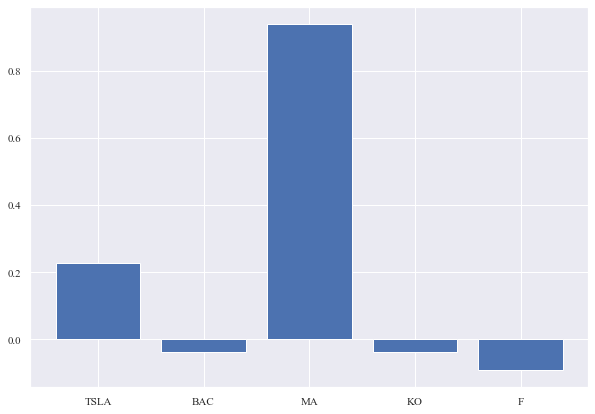

In [27]:
fig = plt.figure(figsize=(10,7))
plt.bar(["TSLA","BAC","MA","KO","F"],wpt)
plt.show()

## Coeficiente de sharpe

$$
\frac{E(r_{p})-r_{p}}{\sigma_{p}}
$$

Cuanta rentabilidad te está dado cada portafolio por unidad de riesgo

preguntas linea 224 y 309

## Linea del mercado de capitales
$$
E(r_{p}) = r_{f} + \frac{E(r_{p})-r_{f}}{\sigma_{m}}\sigma_{p}
$$

# CAPM
vincula un único activo en términos de una relación lineal 

## Retorno del portafolio CAPM
\begin{align}
E(r_{i}) &= r_{f} + (E(r_{m})-r_{f})\beta_{i} \quad \text{;} \quad \beta_{i} = \frac{\sigma_{p}}{\sigma_{m}^{2}} \owntag{8.1a} \\
E(r_{p}) &= w_{i} E(r_{i}) + (1-w_{i})E(R_{m}) \owntag{8.1b}
\end{align}

## Riesgo del portafolio CAPM

\begin{align}
\sigma_{p} &= [w_{i}^{2}\sigma_{i}^{2}+(1-w_{i})\sigma_{m}^{2}+2w_{i}(1-w_{i})\sigma_{i,m}]^{1/2} \owntag{8.2}
\end{align}

## Beta del CAPM
de 8.1a y 8.2, derivando respecto a las ponderaciones obtenemos

\begin{align}
\frac{dE(r_{p})}{d w_{i}} &= E(r_{i}) - E(r_{m}) \owntag{8.3}\\
\frac{d\sigma_{p}}{dw_{i}} &= \frac{[w_{i}\sigma_{i}^{2}-(1-w_{i})\sigma_{m}^{2}+(1-2w_{i})\sigma_{im}]}{\sigma_{p}}
\end{align}

Haciendo el cociente entre 8.3a y 8.3b y evaluado en $w_{i}=0$ obtenemos
\begin{align}
\beta = \frac{dE(r_{p})}{d\sigma_{p}}|_{w_{i}=0}
\end{align}